In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os, sys
import tensorflow as tf

from sklearn.mixture import GaussianMixture
from sklearn.externals import joblib

%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

data = pd.read_excel('../data/record50.xlsx', sheet_name=1, header=0, index_col=0)
data

/Users/JJjie/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


,歌曲（4/4拍·抒情流行音乐）,歌曲转折时间点,开头/前奏 Introduction,主歌 Verse,预副歌 Pre-chorus,副歌 Chorus,桥段 Bridge,结尾 Outro/Conclusion,乐器独奏 ElisionInstrumental Solo
序号,,,,,,,,,
0,彩虹,"00:00 , 00:12 , 01:29 , 01:56 , 02:47 , 03:14 ...",00:00-00:12,00:12-01:29\n01:56-02:47,NaN,01:29-01:56\n02:47-03:14\n03:38-04:09,03:14-03:38,04:09-04:23,(此列暂时不用)
1,孤独患者,NaN,00:00-00:16\n01:31-01:39\n02:54-03:21,00:16-00:48\n01:39-02:09,NaN,00:48-01:31\n02:09-02:54\n03:21-04:07,NaN,04:07-04:32,NaN
2,你的背包,NaN,00:00-00:22\n01:21-01:26\n02:25-02:49,00:22-00:52\n01:26-01:56,NaN,00:52-01:21\n01:56-02:25\n02:49-03:30,NaN,03:30-03:57,NaN
3,伤信,NaN,00:00-00:23,NaN,NaN,NaN,NaN,NaN,NaN
4,淘汰,NaN,00:00-00:34\n02:10-02:24\n03:28-03:43,00:34-01:37\n02:24-02:54,NaN,01:37-02:10\n02:54-03:28\n03:43-04:18,NaN,04:18-04:45,NaN
5,K歌之王,NaN,00:00-00:13\n01:44-01:54,00:13-01:03\n01:54-02:20,NaN,01:03-01:44\n02:20-02:43\n02:55-03:07,02:43-02:55,03:07-03:38,NaN
6,我总是一个人在练习一个人,NaN,00:00-00:14\n01:48-02:03,00:14-01:14,NaN,01:14-01:48\n02:03-02:36,NaN,02:36-03:03,NaN
7,石榴石,NaN,00:00-00:12\n01:44-01:50\n03:23-03:44,00:12-00:41\n01:50-02:19,00:41-01:05\n02:19-02:43\n03:44-04:12,01:05-01:44\n02:43-03:23\n04:12-04:43,NaN,04:43-05:19,NaN
8,老人与海,NaN,00:00-00:36\n02:46-03:07,00:36-00:58\n01:41-02:03\n03:07-03:30,NaN,01:19-01:41\n02:24-02:46,00:58-01:19\n02:03-02:24,03:30-04:27,NaN


In [3]:
# 抽取歌曲的转场点时刻
recordpoint = []
for i in range(data.shape[0]):
    d = data.iloc[i].values
    tmp = []
    for s in d[2:-1]:
        if s is np.nan:
            continue
        s = s.split('\n')
        for si in s:
            st = si.split('-')
            for t in st:
                if t not in tmp:
                    tmp.append(t)
    tmp = sorted(tmp)
    recordpoint.append(",".join(tmp))
    
data['歌曲转折时间点'] = pd.Series(recordpoint, index=data.index)
data

,歌曲（4/4拍·抒情流行音乐）,歌曲转折时间点,开头/前奏 Introduction,主歌 Verse,预副歌 Pre-chorus,副歌 Chorus,桥段 Bridge,结尾 Outro/Conclusion,乐器独奏 ElisionInstrumental Solo
序号,,,,,,,,,
0,彩虹,"00:00,00:12,01:29,01:56,02:47,03:14,03:38,04:0...",00:00-00:12,00:12-01:29\n01:56-02:47,NaN,01:29-01:56\n02:47-03:14\n03:38-04:09,03:14-03:38,04:09-04:23,(此列暂时不用)
1,孤独患者,"00:00,00:16,00:48,01:31,01:39,02:09,02:54,03:2...",00:00-00:16\n01:31-01:39\n02:54-03:21,00:16-00:48\n01:39-02:09,NaN,00:48-01:31\n02:09-02:54\n03:21-04:07,NaN,04:07-04:32,NaN
2,你的背包,"00:00,00:22,00:52,01:21,01:26,01:56,02:25,02:4...",00:00-00:22\n01:21-01:26\n02:25-02:49,00:22-00:52\n01:26-01:56,NaN,00:52-01:21\n01:56-02:25\n02:49-03:30,NaN,03:30-03:57,NaN
3,伤信,"00:00,00:23",00:00-00:23,NaN,NaN,NaN,NaN,NaN,NaN
4,淘汰,"00:00,00:34,01:37,02:10,02:24,02:54,03:28,03:4...",00:00-00:34\n02:10-02:24\n03:28-03:43,00:34-01:37\n02:24-02:54,NaN,01:37-02:10\n02:54-03:28\n03:43-04:18,NaN,04:18-04:45,NaN
5,K歌之王,"00:00,00:13,01:03,01:44,01:54,02:20,02:43,02:5...",00:00-00:13\n01:44-01:54,00:13-01:03\n01:54-02:20,NaN,01:03-01:44\n02:20-02:43\n02:55-03:07,02:43-02:55,03:07-03:38,NaN
6,我总是一个人在练习一个人,"00:00,00:14,01:14,01:48,02:03,02:36,03:03",00:00-00:14\n01:48-02:03,00:14-01:14,NaN,01:14-01:48\n02:03-02:36,NaN,02:36-03:03,NaN
7,石榴石,"00:00,00:12,00:41,01:05,01:44,01:50,02:19,02:4...",00:00-00:12\n01:44-01:50\n03:23-03:44,00:12-00:41\n01:50-02:19,00:41-01:05\n02:19-02:43\n03:44-04:12,01:05-01:44\n02:43-03:23\n04:12-04:43,NaN,04:43-05:19,NaN
8,老人与海,"00:00,00:36,00:58,01:19,01:41,02:03,02:24,02:4...",00:00-00:36\n02:46-03:07,00:36-00:58\n01:41-02:03\n03:07-03:30,NaN,01:19-01:41\n02:24-02:46,00:58-01:19\n02:03-02:24,03:30-04:27,NaN


### 训练时序基因

In [40]:
music_path = '../data/music/'
files = os.listdir(music_path)
# 切分帧长 (1s 划分多少个片段)
sl = 10
genedata = []
for i in range(4):
    d = data.iloc[i].values
    name = d[0] + '.mp3'
    if name in files:
        tempdata, sr = librosa.load(os.path.join(music_path, name))
        sr = int(sr / sl) # 片段长度 2205
        
        # 划分数据
        num_slice = int(tempdata.shape[0] / sr)
        tempdata = tempdata[:num_slice * sr]
        tempslice = np.split(tempdata, num_slice, 0)
        genedata += tempslice    
x = np.array(genedata, dtype=np.float32)

# 聚类基因数
gene_num = 12
clu = GaussianMixture(n_components=gene_num, covariance_type='diag')
clu.fit(x)
# store model
joblib.dump(clu, './model/clu.model')

/Users/JJjie/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


['./clu.model']

### 画图

彩虹.mp3
孤独患者.mp3
INFO:tensorflow:Restoring parameters from ./model/rnn
[4, 8, 159, 168, 178, 193, 215, 220, 225, 228, 245, 255]
歌名：孤独患者.mp3; 一秒内采样数：22050; 一共采样：(6030336,); 歌曲时长：273.48462585034014 s; 节拍数：290
(128, 11779) 

/Users/JJjie/anaconda3/lib/python3.6/site-packages/librosa/core/spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


(1025, 11779) (84, 11779) (12, 2734)


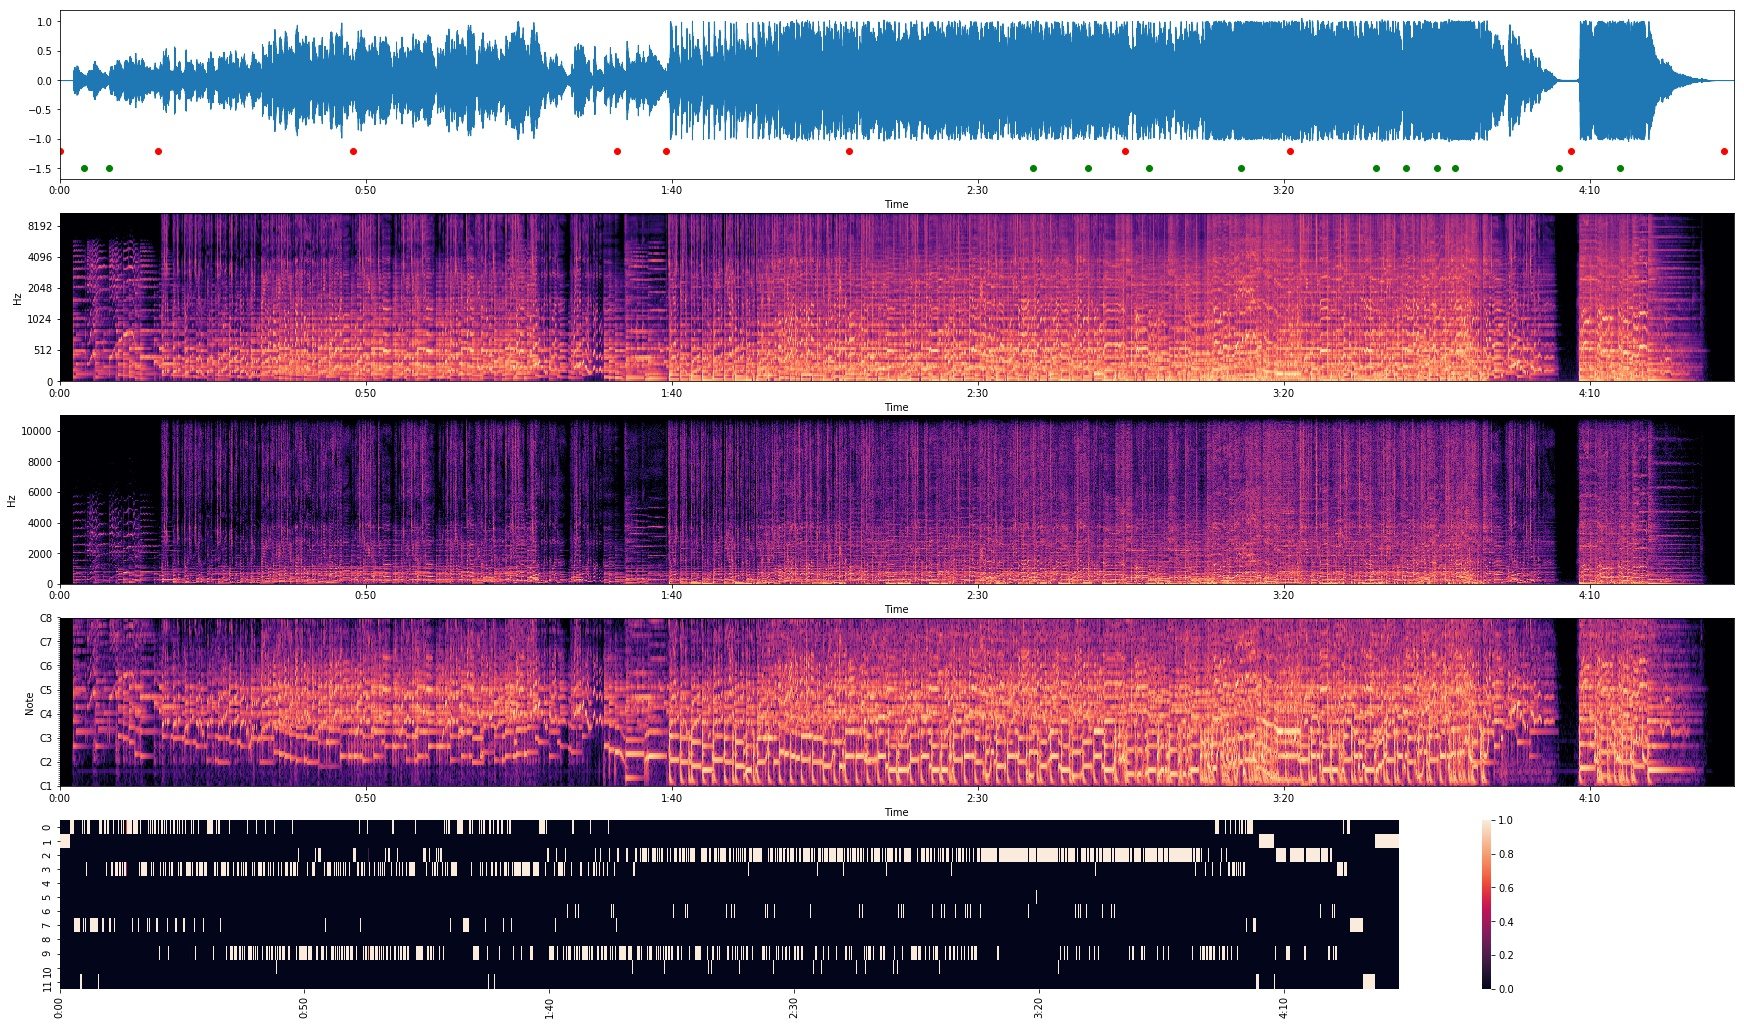

你的背包.mp3
INFO:tensorflow:Restoring parameters from ./model/rnn
[4, 13, 37, 59, 76, 113, 127, 136, 138, 174, 230]
歌名：你的背包.mp3; 一秒内采样数：22050; 一共采样：(5294592,); 歌曲时长：240.11755102040817 s; 节拍数：470
(128, 10342) 

/Users/JJjie/anaconda3/lib/python3.6/site-packages/librosa/core/spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


(1025, 10342) (84, 10342) (12, 2401)


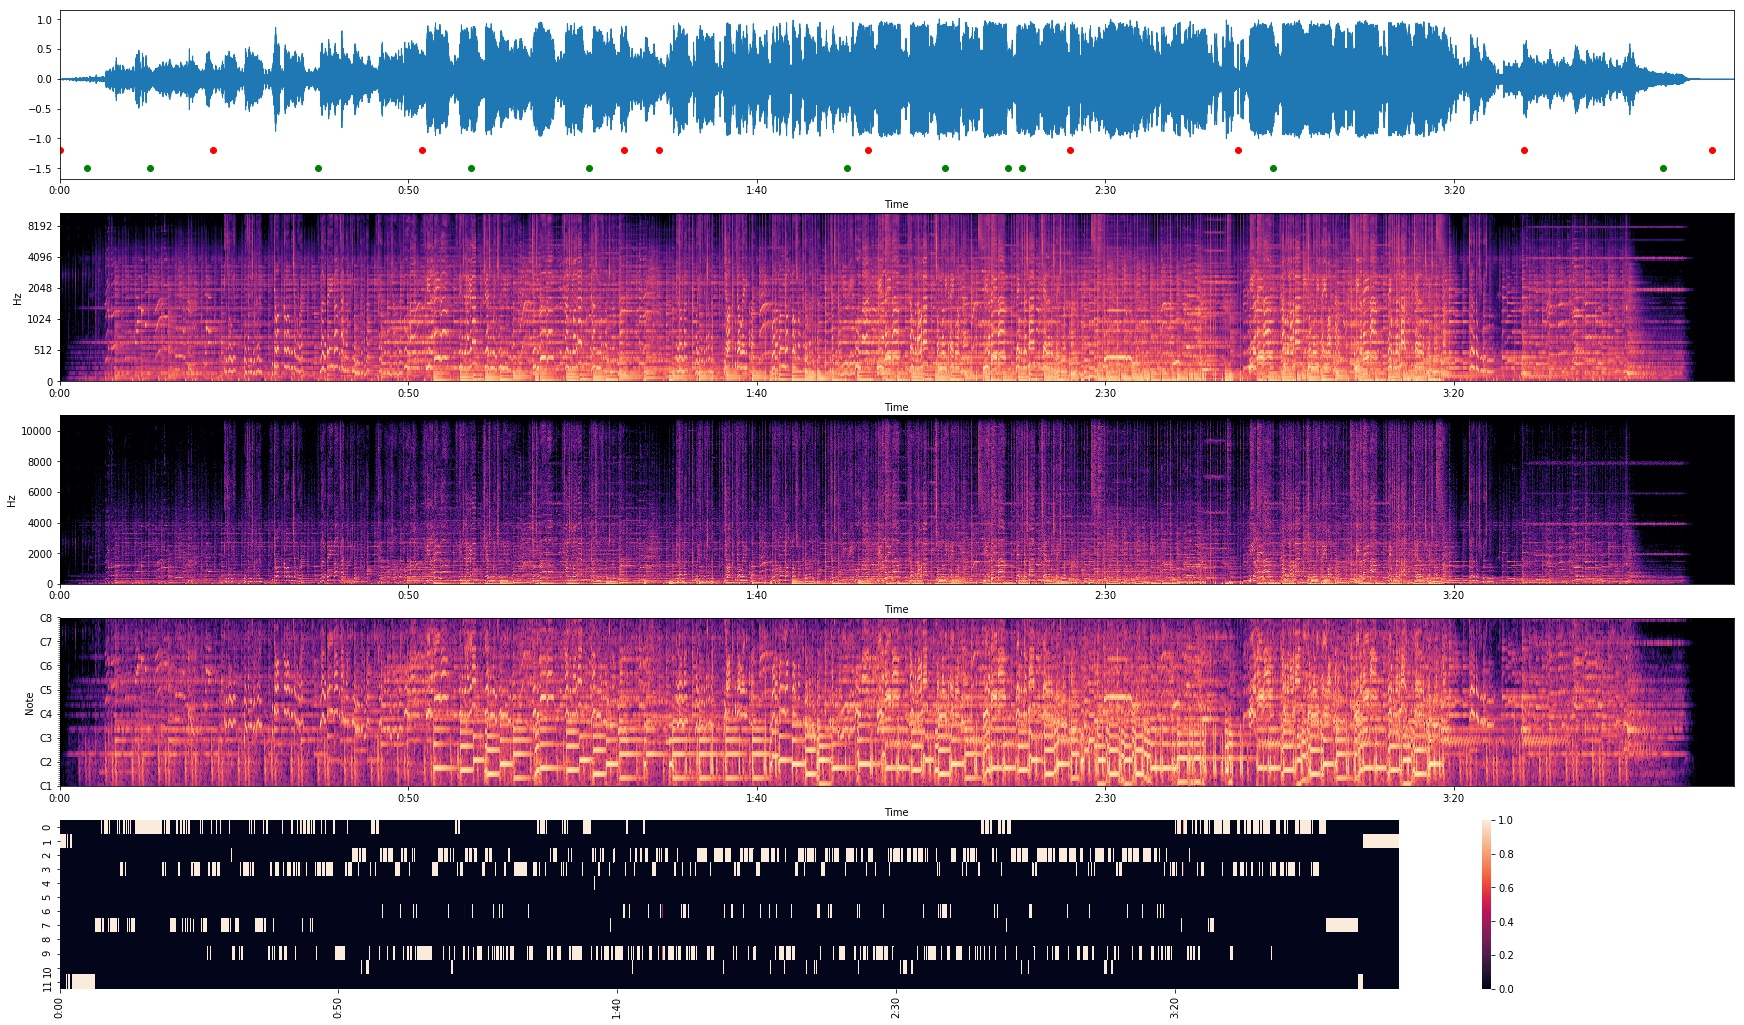

伤信.mp3
INFO:tensorflow:Restoring parameters from ./model/rnn
[4, 11, 16, 29, 47, 53, 151, 271]
歌名：伤信.mp3; 一秒内采样数：22050; 一共采样：(6145920,); 歌曲时长：278.7265306122449 s; 节拍数：728
(128, 12004) (1025, 12004) (84, 12004) (12, 2787)


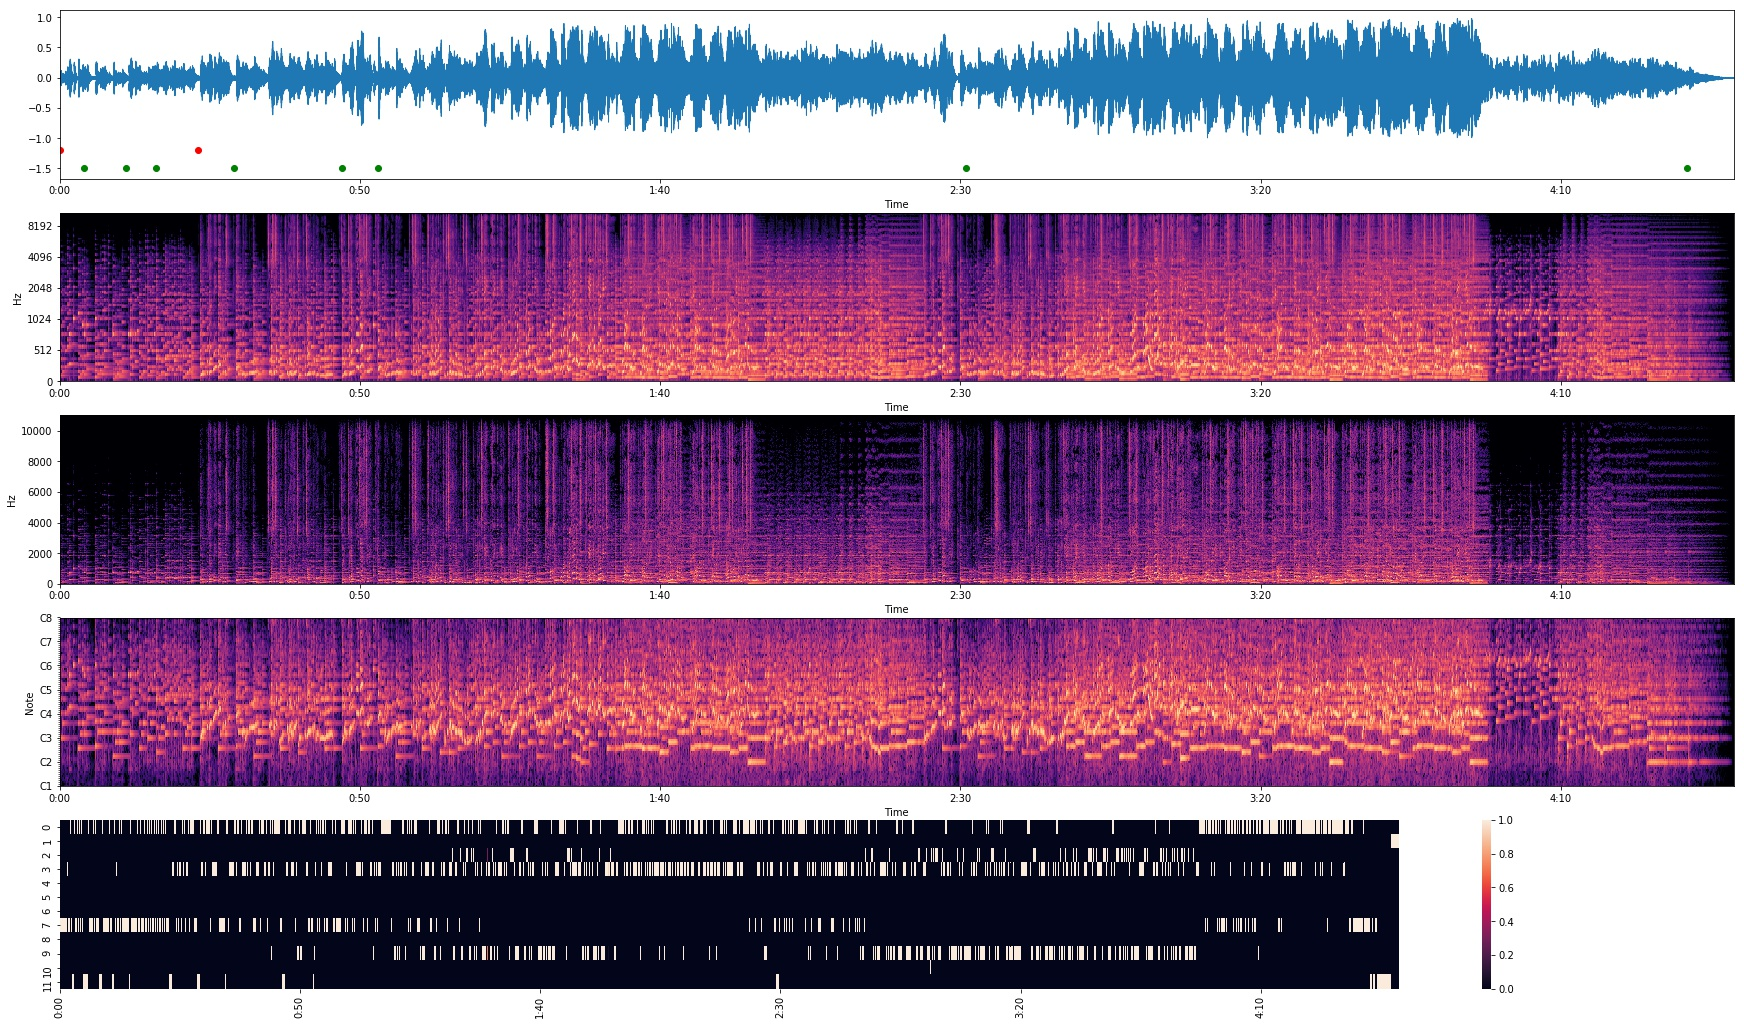

In [9]:
# 输出观察读取音乐的时间曲线
# 加载基因模型
clu = joblib.load('./model/clu.model')
sl = 10

def getpred(datax):
    out = []
    start = 4
    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1.)
    config = tf.ConfigProto(gpu_options=gpu_options)
    with tf.Session(config=config) as sess:
        saver = tf.train.import_meta_graph('./model/rnn.meta')
        saver.restore(sess, './model/rnn')
        graph = tf.get_default_graph()

        input_x = graph.get_tensor_by_name('input_x:0')
        output = graph.get_tensor_by_name('output:0')
        
        y_pred = sess.run(output, feed_dict={input_x: datax})
        y_pred = np.argmax(y_pred, axis=1)
        for y in y_pred:
            if y == 1:
                out.append(start)
            start += 1
        return out

music_path = '../data/music/'
files = os.listdir(music_path)

for i in range(4):
    d = data.iloc[i].values
    name = d[0] + '.mp3'
    points = d[1].split(',')
    print(name)
    if name in files:
        tempdata, sr = librosa.load(os.path.join(music_path, name))
        # 获取音乐时长
        t = librosa.get_duration(tempdata, sr)
        # 获取节拍
        tempo, beats = librosa.beat.beat_track(y=tempdata, sr=sr)
        y_beats = librosa.clicks(frames=beats, sr=sr)
        # 节拍对应时间
        times = librosa.frames_to_time(beats, sr=sr)
        # 获取基因数据
        num_slice = int(tempdata.shape[0] / int(sr/sl))
        tempx = tempdata[:num_slice * int(sr/sl)]
        tempx = np.split(tempx, num_slice, 0)
        G = clu.predict_proba(tempx)
        
        # 分解音乐，时频特性
        S = librosa.feature.melspectrogram(y=tempdata, sr=sr)
        # 分解音乐，短期傅里叶变化，线性频谱功率
        D = librosa.stft(tempdata)
        # 分解音乐，CQT，恒定功率
        CQT = librosa.cqt(tempdata, sr=sr)
        
        # 获取模型预测结果
        x = []
        for i in range(0, len(G)-60, 10):
            x.append(G[i:i+60])
        out = getpred(x)
        y_pred = [out[0]]
        for j in range(1, len(out)):
            if out[j] - out[j-1] > 1:
                y_pred.append(out[j])
        print(y_pred)
        
        print("歌名：{}; 一秒内采样数：{}; 一共采样：{}; 歌曲时长：{} s; 节拍数：{}".format(
            name, sr, tempdata.shape, t, len(beats)))
        
        f, axes = plt.subplots(5, 1, figsize=(30, 18))

        # 画出mfcc曲线
        librosa.display.waveplot(tempdata, sr=sr, x_axis='time', ax=axes[0])
        # 画出转场点
        for p in points:
            ps = p.split(":")
            p = int(ps[0]) * 60 + int(ps[1])
            axes[0].scatter(p, -1.2, c='r')
        for p in y_pred:
            axes[0].scatter(p, -1.5, c='g')
            
        # 画出时频特性
        plotdata = librosa.power_to_db(S, ref=np.max)
        print(plotdata.shape, end=" ")
        librosa.display.specshow(plotdata, x_axis='time', y_axis='mel', ax=axes[1])
        # 画出线性频谱功率
        plotdata = librosa.amplitude_to_db(D, ref=np.max)
        print(plotdata.shape, end=" ")
        librosa.display.specshow(plotdata, x_axis='time', y_axis='linear', ax=axes[2])
        # 画出恒定功率
        plotdata = librosa.amplitude_to_db(CQT, ref=np.max)
        print(plotdata.shape, end=" ")
        librosa.display.specshow(plotdata, x_axis='time', y_axis='cqt_note', ax=axes[3])
        # 画出基因数据
        plotdata = np.transpose(G)
        print(plotdata.shape)
        sns.heatmap(plotdata, vmin=0, vmax=1, linewidths=0., ax=axes[4])
        span = axes[3].get_xticks()
        span = span[1] - span[0]
        axes[4].set_xticks(range(0, plotdata.shape[1], int(span * sl)))
        axes[4].set_xticklabels(axes[3].get_xticklabels()[:-1])
        
        
        plt.show()

### 采样数据集

In [62]:
# 加载基因模型
clu = joblib.load('./clu.model')
sl = 10

# 前后采样长度
# 一个点，取前4s与后2s组成一个样本，判断这个点是不是转场点
left = 4
right = 2

origindata, meldata, stftdata, cqtdata, genedata = [], [], [], [], []
label = []

music_path = '../data/music/'
files = os.listdir(music_path)
for i in range(data.shape[0]):
    d = data.iloc[i].values
    name = d[0] + '.mp3'
    points = d[1].split(',')
    for i in range(len(points)):
        s = points[i].split(':')
        try:
            points[i] = int(s[0]) * 60 + int(s[1])
        except:
            points[i] = 0

    if name in files:
        tempdata, sr = librosa.load(os.path.join(music_path, name))
        # 获取音乐时长
        t = librosa.get_duration(tempdata, sr)
        # 分解音乐，时频特性
        tempmel = np.transpose(librosa.power_to_db(librosa.feature.melspectrogram(y=tempdata, sr=sr), ref=np.max))
        # 分解音乐，短期傅里叶变化，线性频谱功率
        tempstft = np.transpose(librosa.amplitude_to_db(librosa.stft(tempdata), ref=np.max))
        # 分解音乐，CQT，恒定功率
        tempcqt = np.transpose(librosa.amplitude_to_db(librosa.cqt(tempdata, sr=sr), ref=np.max))
        # 分解音乐，基因
        num_slice = int(tempdata.shape[0] / int(sr/sl))
        tempx = tempdata[:num_slice * int(sr/sl)]
        tempx = np.split(tempx, num_slice, 0)
        tempgene = clu.predict_proba(tempx)
        print("歌名：{}; 一秒采样数：{}; 共采样：{}; 时长：{} s; 时频：{}; 功率：{}; CQT：{}; 基因：{};".format(
            name, sr, tempdata.shape[0], t, tempmel.shape, tempstft.shape, tempcqt.shape, tempgene.shape))
        
        # 获取每种数据，一秒内的采样个数
        sr, tsr, gsr = sr, int(tempmel.shape[0]/t), sl
        
        i = 0
        while (i+left+right) < t:
            origindata.append(tempdata[i*sr: (i+left+right)*sr])
            meldata.append(tempmel[i*tsr: (i+left+right)*tsr])
            stftdata.append(tempstft[i*tsr: (i+left+right)*tsr])
            cqtdata.append(tempcqt[i*tsr: (i+left+right)*tsr])
            genedata.append(tempgene[i*gsr: (i+left+right)*gsr])
            
            if (i+left) in points:
                label.append(1)
            else:
                label.append(0)
            i += 1
        
print(np.shape(origindata), np.shape(meldata), np.shape(stftdata), 
      np.shape(cqtdata), np.shape(genedata), np.shape(label))
print(sum(label), len(label)-sum(label))

np.save('../data/dataset/origindata.npy', origindata)
np.save('../data/dataset/meldata.npy', meldata)
np.save('../data/dataset/stftdata.npy', stftdata)
np.save('../data/dataset/cqtdata.npy', cqtdata)
np.save('../data/dataset/genedata.npy', genedata)
np.save('../data/dataset/label.npy', label)

/Users/JJjie/anaconda3/lib/python3.6/site-packages/librosa/core/spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


歌名：孤独患者.mp3; 一秒采样数：22050; 共采样：6030336; 时长：273.48462585034014 s; 时频：(11779, 128); 功率：(11779, 1025); CQT：(11779, 84); 基因：(2734, 12);
歌名：你的背包.mp3; 一秒采样数：22050; 共采样：5294592; 时长：240.11755102040817 s; 时频：(10342, 128); 功率：(10342, 1025); CQT：(10342, 84); 基因：(2401, 12);
歌名：伤信.mp3; 一秒采样数：22050; 共采样：6145920; 时长：278.7265306122449 s; 时频：(12004, 128); 功率：(12004, 1025); CQT：(12004, 84); 基因：(2787, 12);
歌名：淘汰.mp3; 一秒采样数：22050; 共采样：6283264; 时长：284.95528344671203 s; 时频：(12273, 128); 功率：(12273, 1025); CQT：(12273, 84); 基因：(2849, 12);
歌名：K歌之王.mp3; 一秒采样数：22050; 共采样：4817664; 时长：218.48816326530613 s; 时频：(9410, 128); 功率：(9410, 1025); CQT：(9410, 84); 基因：(2184, 12);
歌名：我总是一个人在练习一个人.mp3; 一秒采样数：22050; 共采样：4039488; 时长：183.19673469387754 s; 时频：(7890, 128); 功率：(7890, 1025); CQT：(7890, 84); 基因：(1831, 12);
歌名：石榴石.mp3; 一秒采样数：22050; 共采样：7037952; 时长：319.18149659863946 s; 时频：(13747, 128); 功率：(13747, 1025); CQT：(13747, 84); 基因：(3191, 12);
歌名：老人与海.mp3; 一秒采样数：22050; 共采样：4250880; 时长：192.78367346938776 s; 时频：(8303, 128); 功率：(830